# Data Preparation - RoundtableAI

**Project:** LLM-Based Multi-Agent System for Bursa Stock Analysis

**Author:** Ryan Chin Jian Hwa

**Course:** WIH3001 Data Science Project

---

## CRISP-DM: Data Preparation Phase

This notebook follows the CRISP-DM methodology for data preparation:

1. **Data Selection** - Select relevant data from MongoDB collections
2. **Data Cleaning** - Handle missing values, duplicates, outliers
3. **Data Construction** - Derive new attributes if needed
4. **Data Integration** - Merge data from different collections
5. **Data Formatting** - Ensure consistent formats

## Collections to Prepare
- `fundamentals` - Financial metrics (PE ratio, ROE, etc.)
- `stock_prices` - Historical price data
- `articles` - News articles with sentiment scores

## 1. Setup and Data Loading

In [54]:
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# MongoDB connection using existing database utility
from utils.database import get_mongo_client, get_mongo_database

# Connect to MongoDB using the configured client
client = get_mongo_client()
db = get_mongo_database('bursa_stocks')  # Using your actual database name

print(f"Connected to MongoDB")
print(f"Database: {db.name}")
print(f"Collections: {db.list_collection_names()}")

Connected to MongoDB
Database: roundtable_ai
Collections: ['stock_prices', 'fundamentals', 'articles']


## 2. Data Inspection - Fundamentals Collection

In [55]:
# Load fundamentals data
fundamentals_cursor = db.fundamentals.find()
fundamentals_list = list(fundamentals_cursor)

print(f"Total documents in fundamentals: {len(fundamentals_list)}")
print(f"\nSample document structure:")
if fundamentals_list:
    import pprint
    pprint.pprint(fundamentals_list[0])

Total documents in fundamentals: 996

Sample document structure:
{'_id': ObjectId('6937d7d7d9cab39681ec611d'),
 'annual_balance_sheet': {},
 'annual_cashflow': {},
 'annual_income': {},
 'company_name': 'ABF Malaysia Bond Index',
 'data_quality_balance_sheet': {'annual_data_available': False,
                                'annual_periods': 0,
                                'data_freshness': 'Unknown',
                                'missing_data_percentage': 0,
                                'quarterly_data_available': False,
                                'quarterly_periods': 0},
 'data_quality_cashflow': {'annual_data_available': False,
                           'annual_periods': 0,
                           'data_freshness': 'Unknown',
                           'missing_data_percentage': 0,
                           'quarterly_data_available': False,
                           'quarterly_periods': 0},
 'data_quality_income': {'annual_data_available': False,
               

In [56]:
# Convert to DataFrame for easier analysis
fundamentals_df = pd.DataFrame(fundamentals_list)

print("Fundamentals DataFrame Info:")
print(f"Shape: {fundamentals_df.shape}")
print(f"\nColumns: {fundamentals_df.columns.tolist()}")
print(f"\nData types:")
print(fundamentals_df.dtypes)

# Identify nested fields
nested_fields = []
for col in fundamentals_df.columns:
    if fundamentals_df[col].dtype == 'object':
        # Check if it's a dict
        sample = fundamentals_df[col].dropna().iloc[0] if len(fundamentals_df[col].dropna()) > 0 else None
        if isinstance(sample, dict):
            nested_fields.append(col)

print(f"\nNested fields detected: {nested_fields}")

Fundamentals DataFrame Info:
Shape: (996, 15)

Columns: ['_id', 'ticker', 'company_name', 'sector', 'industry', 'metrics', 'quarterly_income', 'quarterly_balance_sheet', 'quarterly_cashflow', 'annual_income', 'annual_balance_sheet', 'annual_cashflow', 'data_quality_income', 'data_quality_balance_sheet', 'data_quality_cashflow']

Data types:
_id                           object
ticker                        object
company_name                  object
sector                        object
industry                      object
metrics                       object
quarterly_income              object
quarterly_balance_sheet       object
quarterly_cashflow            object
annual_income                 object
annual_balance_sheet          object
annual_cashflow               object
data_quality_income           object
data_quality_balance_sheet    object
data_quality_cashflow         object
dtype: object

Nested fields detected: ['metrics', 'quarterly_income', 'quarterly_balance_sheet', 'qua

### 2.1 Flatten Nested Fields for Analysis

In [57]:
# Flatten nested fields into separate columns
def flatten_nested_fields(df, nested_cols):
    """Flatten nested dictionary columns into separate columns."""
    df_flat = df.copy()
    
    for col in nested_cols:
        # Extract all keys from the nested dictionaries
        all_keys = set()
        for item in df_flat[col].dropna():
            if isinstance(item, dict):
                all_keys.update(item.keys())
        
        # Create new columns for each key
        for key in all_keys:
            new_col_name = f"{col}.{key}"
            df_flat[new_col_name] = df_flat[col].apply(
                lambda x: x.get(key) if isinstance(x, dict) else None
            )
        
        # Drop the original nested column
        df_flat = df_flat.drop(columns=[col])
    
    return df_flat

# Flatten the DataFrame
if nested_fields:
    print(f"Flattening {len(nested_fields)} nested fields...")
    fundamentals_flat = flatten_nested_fields(fundamentals_df, nested_fields)
    print(f"✓ Flattened DataFrame shape: {fundamentals_flat.shape}")
    print(f"\\nNew columns created:")
    
    # Show new flattened columns
    new_cols = [col for col in fundamentals_flat.columns if '.' in col]
    for field in nested_fields:
        field_cols = [col for col in new_cols if col.startswith(f"{field}.")]
        if field_cols:
            print(f"  {field}: {len(field_cols)} sub-fields")
            print(f"    {', '.join(field_cols[:10])}")  # Show first 10
            if len(field_cols) > 10:
                print(f"    ... and {len(field_cols) - 10} more")
else:
    fundamentals_flat = fundamentals_df
    print("No nested fields to flatten")

Flattening 10 nested fields...
✓ Flattened DataFrame shape: (996, 260)
\nNew columns created:
  metrics: 3 sub-fields
    metrics.financial_health, metrics.valuation, metrics.growth
  quarterly_income: 20 sub-fields
    quarterly_income.2025-04-30, quarterly_income.2024-09-30, quarterly_income.2025-01-31, quarterly_income.2025-02-28, quarterly_income.2025-07-31, quarterly_income.2025-06-30, quarterly_income.2025-10-31, quarterly_income.2024-03-31, quarterly_income.2024-08-31, quarterly_income.2025-09-30
    ... and 10 more
  quarterly_balance_sheet: 20 sub-fields
    quarterly_balance_sheet.2025-04-30, quarterly_balance_sheet.2024-09-30, quarterly_balance_sheet.2025-01-31, quarterly_balance_sheet.2025-02-28, quarterly_balance_sheet.2025-07-31, quarterly_balance_sheet.2025-06-30, quarterly_balance_sheet.2025-10-31, quarterly_balance_sheet.2024-03-31, quarterly_balance_sheet.2024-08-31, quarterly_balance_sheet.2025-09-30
    ... and 10 more
  quarterly_cashflow: 20 sub-fields
    quarter

### 2.2 Missing Values Analysis - Fundamentals (Flattened)

Missing Values Analysis - Fundamentals (with nested fields flattened):


,Column,Missing_Count,Missing_Percentage,Data_Type
quarterly_income.2025-10-31,quarterly_income.2025-10-31,992,99.6,object
quarterly_cashflow.2025-10-31,quarterly_cashflow.2025-10-31,992,99.6,object
quarterly_balance_sheet.2025-10-31,quarterly_balance_sheet.2025-10-31,992,99.6,object
annual_income.2021-02-28,annual_income.2021-02-28,990,99.4,object
annual_cashflow.2022-11-30,annual_cashflow.2022-11-30,989,99.3,object
annual_balance_sheet.2023-11-30,annual_balance_sheet.2023-11-30,989,99.3,object
annual_income.2022-11-30,annual_income.2022-11-30,989,99.3,object
annual_income.2023-11-30,annual_income.2023-11-30,989,99.3,object
annual_cashflow.2023-11-30,annual_cashflow.2023-11-30,989,99.3,object
annual_balance_sheet.2022-11-30,annual_balance_sheet.2022-11-30,989,99.3,object


\nMissing data summary by category:
  Columns with 100% missing (remove candidates): 0
  Columns with 50-99% missing (caution): 204
  Columns with 1-49% missing (imputable): 33
  Columns with 0% missing (complete): 23


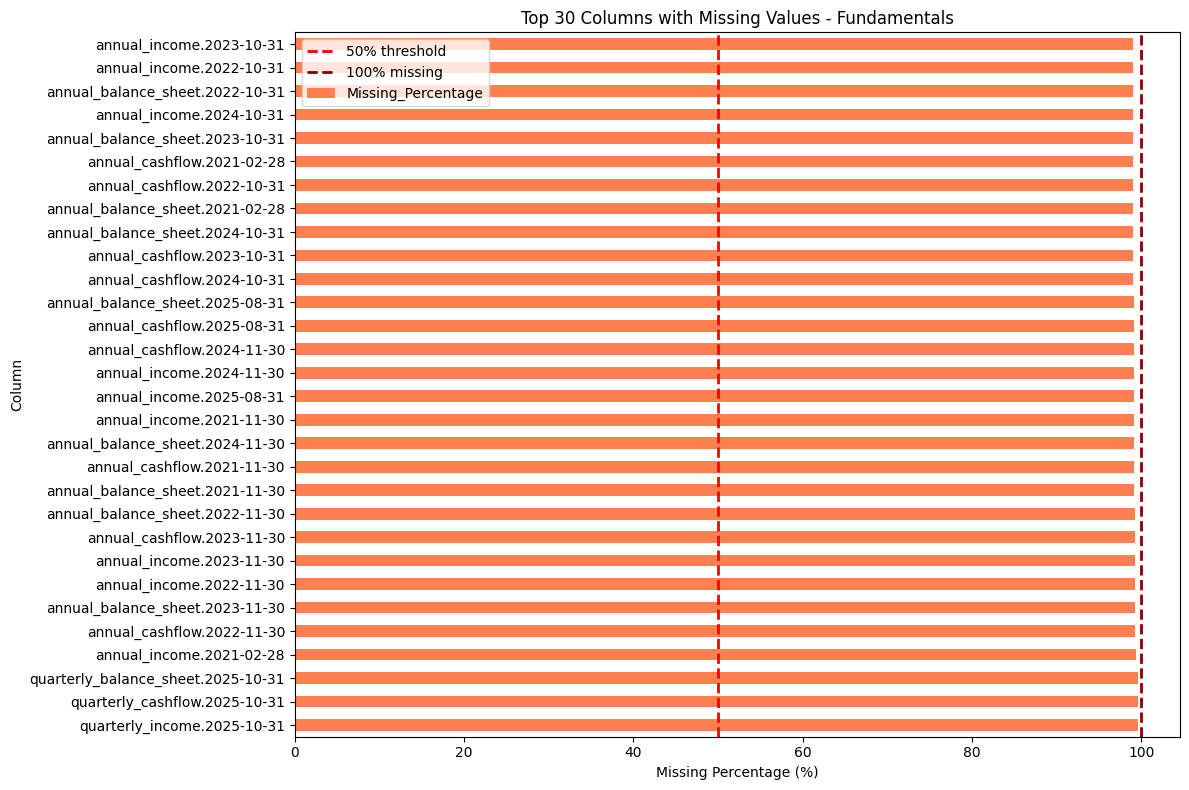

In [58]:
# Analyze missing values in FLATTENED DataFrame
missing_analysis = pd.DataFrame({
    'Column': fundamentals_flat.columns,
    'Missing_Count': fundamentals_flat.isnull().sum(),
    'Missing_Percentage': (fundamentals_flat.isnull().sum() / len(fundamentals_flat) * 100).round(2),
    'Data_Type': fundamentals_flat.dtypes
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Values Analysis - Fundamentals (with nested fields flattened):")
print("="*70)
display(missing_analysis.head(30))  # Show top 30 columns with most missing data

# Show summary by category
print("\\nMissing data summary by category:")
print(f"  Columns with 100% missing (remove candidates): {len(missing_analysis[missing_analysis['Missing_Percentage'] == 100])}")
print(f"  Columns with 50-99% missing (caution): {len(missing_analysis[(missing_analysis['Missing_Percentage'] >= 50) & (missing_analysis['Missing_Percentage'] < 100)])}")
print(f"  Columns with 1-49% missing (imputable): {len(missing_analysis[(missing_analysis['Missing_Percentage'] > 0) & (missing_analysis['Missing_Percentage'] < 50)])}")
print(f"  Columns with 0% missing (complete): {len(missing_analysis[missing_analysis['Missing_Percentage'] == 0])}")

# Visualize missing data
fig, ax = plt.subplots(figsize=(12, 8))
missing_pct = missing_analysis[missing_analysis['Missing_Percentage'] > 0].head(30)
if not missing_pct.empty:
    missing_pct.plot(x='Column', y='Missing_Percentage', kind='barh', ax=ax, color='coral')
    ax.set_xlabel('Missing Percentage (%)')
    ax.set_title('Top 30 Columns with Missing Values - Fundamentals')
    ax.axvline(x=50, color='red', linestyle='--', label='50% threshold', linewidth=2)
    ax.axvline(x=100, color='darkred', linestyle='--', label='100% missing', linewidth=2)
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("\\n✓ No missing values found!")

### 2.3 Duplicate Analysis - Fundamentals

In [59]:
# Identify numerical columns from FLATTENED DataFrame
numerical_cols = fundamentals_flat.select_dtypes(include=[np.number]).columns.tolist()
if '_id' in numerical_cols:
    numerical_cols.remove('_id')

print(f"Numerical columns found in flattened data: {len(numerical_cols)}")

# Show numerical columns by category
metrics_cols = [col for col in numerical_cols if col.startswith('metrics.')]
income_cols = [col for col in numerical_cols if 'income' in col.lower()]
balance_cols = [col for col in numerical_cols if 'balance' in col.lower()]
cashflow_cols = [col for col in numerical_cols if 'cashflow' in col.lower()]
other_cols = [col for col in numerical_cols if col not in metrics_cols + income_cols + balance_cols + cashflow_cols]

print(f"\nNumerical columns by category:")
print(f"  Metrics fields: {len(metrics_cols)}")
print(f"  Income statement: {len(income_cols)}")
print(f"  Balance sheet: {len(balance_cols)}")
print(f"  Cash flow: {len(cashflow_cols)}")
print(f"  Other: {len(other_cols)}")

# Statistical summary for key metrics (showing first 20)
if metrics_cols:
    print(f"\nKey metrics summary (showing first 20):")
    display(fundamentals_flat[metrics_cols[:20]].describe())

Numerical columns found in flattened data: 9

Numerical columns by category:
  Metrics fields: 0
  Income statement: 3
  Balance sheet: 3
  Cash flow: 3
  Other: 0


In [ ]:
# Check for outliers using IQR method on FLATTENED DataFrame
def detect_outliers_iqr(df, columns):
    """Detect outliers using IQR method."""
    outlier_summary = []
    
    for col in columns:
        # Skip columns with all NaN
        if df[col].isna().all():
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        if IQR == 0:  # Skip if no variation
            continue
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        
        outlier_summary.append({
            'Column': col,
            'Outlier_Count': len(outliers),
            'Outlier_Percentage': round(len(outliers) / len(df.dropna(subset=[col])) * 100, 2) if len(df.dropna(subset=[col])) > 0 else 0,
            'Lower_Bound': round(lower_bound, 2),
            'Upper_Bound': round(upper_bound, 2),
            'Min': round(df[col].min(), 2),
            'Max': round(df[col].max(), 2)
        })
    
    return pd.DataFrame(outlier_summary).sort_values('Outlier_Percentage', ascending=False)

if numerical_cols:
    print("Detecting outliers in numerical columns (this may take a moment)...")
    outliers_df = detect_outliers_iqr(fundamentals_flat, numerical_cols)
    
    print(f"\nOutlier Analysis (IQR Method) - Top 20 columns:")
    print("="*70)
    display(outliers_df.head(20))
    
    # Summary
    high_outliers = len(outliers_df[outliers_df['Outlier_Percentage'] > 10])
    print(f"\nColumns with >10% outliers: {high_outliers}")
else:
    print("No numerical columns to analyze")

## 3. Data Inspection - Stock Prices Collection

In [60]:
# Load stock prices data
stock_prices_cursor = db.stock_prices.find()
stock_prices_list = list(stock_prices_cursor)

print(f"Total documents in stock_prices: {len(stock_prices_list)}")
print(f"\nSample document structure:")
if stock_prices_list:
    pprint.pprint(stock_prices_list[0])

Total documents in stock_prices: 1159523

Sample document structure:
{'_id': ObjectId('692f088346167f3c16773bd1'),
 'close': 1.1960614919662476,
 'date': '2020-12-02',
 'high': 1.2052619565445888,
 'low': 1.1868610273879063,
 'open': 1.1960614919662476,
 'ticker': '5250.KL',
 'volume': 985600}


In [61]:
# Convert to DataFrame
stock_prices_df = pd.DataFrame(stock_prices_list)

print("Stock Prices DataFrame Info:")
print(f"Shape: {stock_prices_df.shape}")
print(f"\nColumns: {stock_prices_df.columns.tolist()}")
print(f"\nData types:")
print(stock_prices_df.dtypes)

Stock Prices DataFrame Info:
Shape: (1159523, 8)

Columns: ['_id', 'ticker', 'date', 'open', 'high', 'low', 'close', 'volume']

Data types:
_id        object
ticker     object
date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object


### 3.1 Date Range and Consistency - Stock Prices

In [62]:
# Analyze date column
date_col = None
for col in ['date', 'timestamp', 'datetime', 'Date']:
    if col in stock_prices_df.columns:
        date_col = col
        break

if date_col:
    # Convert to datetime if needed
    if stock_prices_df[date_col].dtype == 'object':
        stock_prices_df[date_col] = pd.to_datetime(stock_prices_df[date_col], errors='coerce')
    
    print(f"Date column: {date_col}")
    print(f"Date range: {stock_prices_df[date_col].min()} to {stock_prices_df[date_col].max()}")
    print(f"Total days covered: {(stock_prices_df[date_col].max() - stock_prices_df[date_col].min()).days}")
    print(f"\nDate data type: {stock_prices_df[date_col].dtype}")
    print(f"Invalid dates: {stock_prices_df[date_col].isna().sum()}")
else:
    print("Warning: No date column found in stock_prices")

Date column: date
Date range: 2020-12-02 00:00:00 to 2025-12-02 00:00:00
Total days covered: 1826

Date data type: datetime64[ns]
Invalid dates: 0


### 3.2 Missing Values and Data Quality - Stock Prices

In [52]:
# Missing values analysis
missing_prices = pd.DataFrame({
    'Column': stock_prices_df.columns,
    'Missing_Count': stock_prices_df.isnull().sum(),
    'Missing_Percentage': (stock_prices_df.isnull().sum() / len(stock_prices_df) * 100).round(2),
    'Data_Type': stock_prices_df.dtypes
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Values Analysis - Stock Prices:")
print("="*70)
display(missing_prices)

Missing Values Analysis - Stock Prices:


,Column,Missing_Count,Missing_Percentage,Data_Type
_id,_id,0,0.0,object
ticker,ticker,0,0.0,object
date,date,0,0.0,datetime64[ns]
open,open,0,0.0,float64
high,high,0,0.0,float64
low,low,0,0.0,float64
close,close,0,0.0,float64
volume,volume,0,0.0,int64


In [ ]:
# Check data completeness by ticker
if 'ticker' in stock_prices_df.columns:
    ticker_stats = stock_prices_df.groupby('ticker').agg({
        date_col if date_col else stock_prices_df.columns[0]: ['count', 'min', 'max']
    }).reset_index()
    
    ticker_stats.columns = ['ticker', 'record_count', 'earliest_date', 'latest_date']
    
    print("\nData completeness by ticker:")
    print(f"Total unique tickers: {ticker_stats['ticker'].nunique()}")
    print(f"\nRecord count statistics:")
    print(ticker_stats['record_count'].describe())
    
    print("\nTickers with fewest records:")
    display(ticker_stats.nsmallest(10, 'record_count'))

### 3.3 Price Data Validation

In [ ]:
# Check for negative or zero prices
price_cols = ['open', 'high', 'low', 'close', 'Open', 'High', 'Low', 'Close']
price_cols = [col for col in price_cols if col in stock_prices_df.columns]

if price_cols:
    print("Price validation checks:")
    for col in price_cols:
        negative = (stock_prices_df[col] < 0).sum()
        zero = (stock_prices_df[col] == 0).sum()
        print(f"  {col}: {negative} negative values, {zero} zero values")
    
    # Check High >= Low
    if 'high' in price_cols and 'low' in price_cols:
        invalid_range = (stock_prices_df['high'] < stock_prices_df['low']).sum()
        print(f"\nInvalid price ranges (High < Low): {invalid_range}")
    elif 'High' in price_cols and 'Low' in price_cols:
        invalid_range = (stock_prices_df['High'] < stock_prices_df['Low']).sum()
        print(f"\nInvalid price ranges (High < Low): {invalid_range}")

## 4. Data Inspection - Articles Collection

In [ ]:
# Load articles data
articles_cursor = db.articles.find()
articles_list = list(articles_cursor)

print(f"Total documents in articles: {len(articles_list)}")
print(f"\nSample document structure:")
if articles_list:
    pprint.pprint(articles_list[0])

In [ ]:
# Convert to DataFrame
articles_df = pd.DataFrame(articles_list)

print("Articles DataFrame Info:")
print(f"Shape: {articles_df.shape}")
print(f"\nColumns: {articles_df.columns.tolist()}")
print(f"\nData types:")
print(articles_df.dtypes)

# Check for nested fields in articles
articles_nested_fields = []
for col in articles_df.columns:
    if articles_df[col].dtype == 'object':
        sample = articles_df[col].dropna().iloc[0] if len(articles_df[col].dropna()) > 0 else None
        if isinstance(sample, dict):
            articles_nested_fields.append(col)

print(f"\nNested fields detected: {articles_nested_fields}")

# Flatten if needed
if articles_nested_fields:
    print(f"\nFlattening {len(articles_nested_fields)} nested fields...")
    articles_flat = flatten_nested_fields(articles_df, articles_nested_fields)
    print(f"✓ Flattened DataFrame shape: {articles_flat.shape}")
else:
    articles_flat = articles_df
    print("\nNo nested fields to flatten")

### 4.1 Missing Values Analysis - Articles

In [ ]:
# Missing values analysis on FLATTENED articles DataFrame
missing_articles = pd.DataFrame({
    'Column': articles_flat.columns,
    'Missing_Count': articles_flat.isnull().sum(),
    'Missing_Percentage': (articles_flat.isnull().sum() / len(articles_flat) * 100).round(2),
    'Data_Type': articles_flat.dtypes
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Values Analysis - Articles (with nested fields flattened):")
print("="*70)
display(missing_articles)

### 4.2 Sentiment Score Distribution

In [ ]:
# Analyze sentiment scores (check for flattened sentiment fields)
sentiment_col = None

# Try to find sentiment score column (may be flattened)
for col in articles_flat.columns:
    if 'sentiment' in col.lower() and articles_flat[col].dtype in ['float64', 'int64']:
        sentiment_col = col
        break

if sentiment_col:
    print(f"Sentiment column: {sentiment_col}")
    print(f"\nSentiment statistics:")
    print(articles_flat[sentiment_col].describe())
    
    # Visualize distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    articles_flat[sentiment_col].hist(bins=50, ax=axes[0], edgecolor='black')
    axes[0].set_xlabel('Sentiment Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Sentiment Score Distribution')
    axes[0].axvline(x=0, color='red', linestyle='--', label='Neutral')
    axes[0].legend()
    
    # Box plot
    articles_flat.boxplot(column=sentiment_col, ax=axes[1])
    axes[1].set_ylabel('Sentiment Score')
    axes[1].set_title('Sentiment Score Box Plot')
    
    plt.tight_layout()
    plt.show()
    
    # Sentiment classification
    positive = (articles_flat[sentiment_col] > 0).sum()
    negative = (articles_flat[sentiment_col] < 0).sum()
    neutral = (articles_flat[sentiment_col] == 0).sum()
    null_count = articles_flat[sentiment_col].isna().sum()
    
    print(f"\nSentiment distribution:")
    print(f"  Positive: {positive} ({positive/len(articles_flat)*100:.1f}%)")
    print(f"  Negative: {negative} ({negative/len(articles_flat)*100:.1f}%)")
    print(f"  Neutral: {neutral} ({neutral/len(articles_flat)*100:.1f}%)")
    print(f"  Missing: {null_count} ({null_count/len(articles_flat)*100:.1f}%)")
else:
    print("Warning: No numerical sentiment column found")
    print("\nAvailable sentiment-related columns:")
    sentiment_cols = [col for col in articles_flat.columns if 'sentiment' in col.lower()]
    for col in sentiment_cols:
        print(f"  {col}: {articles_flat[col].dtype}")

### 4.3 Duplicate Articles Check

In [ ]:
# Check for duplicate articles (by title or URL) - using flattened DataFrame
title_col = None
for col in ['title', 'headline', 'Title']:
    if col in articles_flat.columns:
        title_col = col
        break

if title_col:
    duplicate_titles = articles_flat[articles_flat.duplicated(subset=[title_col], keep=False)]
    print(f"Duplicate articles (by {title_col}): {len(duplicate_titles)}")
    
    if len(duplicate_titles) > 0:
        cols_to_show = [title_col]
        if 'ticker' in articles_flat.columns:
            cols_to_show.append('ticker')
        print("\nSample duplicate titles:")
        display(duplicate_titles[cols_to_show].head(10))
else:
    print("Warning: No title column found for duplicate detection")

# Check exact row duplicates
exact_dup = articles_flat.duplicated().sum()
print(f"\nExact duplicate rows: {exact_dup}")

## 5. Cross-Collection Data Quality Checks

In [50]:
# Check ticker consistency across collections (using flattened DataFrames)
tickers_fundamentals = set(fundamentals_flat['ticker'].unique()) if 'ticker' in fundamentals_flat.columns else set()
tickers_prices = set(stock_prices_df['ticker'].unique()) if 'ticker' in stock_prices_df.columns else set()
tickers_articles = set(articles_flat['ticker'].unique()) if 'ticker' in articles_flat.columns else set()

print("Ticker Consistency Across Collections:")
print("="*70)
print(f"Unique tickers in fundamentals: {len(tickers_fundamentals)}")
print(f"Unique tickers in stock_prices: {len(tickers_prices)}")
print(f"Unique tickers in articles: {len(tickers_articles)}")

# Find tickers in fundamentals but not in stock_prices
missing_price_tickers = tickers_fundamentals - tickers_prices
if missing_price_tickers:
    print(f"\n⚠ Tickers in fundamentals but missing in stock_prices: {len(missing_price_tickers)}")
    print(f"   {sorted(list(missing_price_tickers))[:10]}")
    if len(missing_price_tickers) > 10:
        print(f"   ... and {len(missing_price_tickers) - 10} more")

# Find tickers in fundamentals but not in articles
missing_articles_tickers = tickers_fundamentals - tickers_articles
if missing_articles_tickers:
    print(f"\n⚠ Tickers in fundamentals but missing in articles: {len(missing_articles_tickers)}")
    print(f"   {sorted(list(missing_articles_tickers))[:10]}")
    if len(missing_articles_tickers) > 10:
        print(f"   ... and {len(missing_articles_tickers) - 10} more")

# Find common tickers across all collections
common_tickers = tickers_fundamentals & tickers_prices & tickers_articles
print(f"\n✓ Tickers present in all three collections: {len(common_tickers)}")

Ticker Consistency Across Collections:
Unique tickers in fundamentals: 990
Unique tickers in stock_prices: 990
Unique tickers in articles: 390

⚠ Tickers in fundamentals but missing in articles: 990
   ['0001.KL', '0002.KL', '0005.KL', '0006.KL', '0007.KL', '0008.KL', '0010.KL', '0011.KL', '0012.KL', '0017.KL']
   ... and 980 more

✓ Tickers present in all three collections: 0


## 6. Data Quality Summary Report

In [ ]:
# Generate comprehensive data quality report (using flattened DataFrames)
print("="*70)
print("DATA QUALITY SUMMARY REPORT")
print("="*70)

print("\n1. FUNDAMENTALS COLLECTION")
print("-" * 50)
print(f"   Total records: {len(fundamentals_flat)}")
print(f"   Total columns (flattened): {len(fundamentals_flat.columns)}")
print(f"   Columns with 100% missing: {len(missing_analysis[missing_analysis['Missing_Percentage'] == 100])}")
print(f"   Columns with >50% missing: {len(missing_analysis[missing_analysis['Missing_Percentage'] > 50])}")
print(f"   Duplicate rows: {fundamentals_flat.duplicated().sum()}")

print("\n2. STOCK PRICES COLLECTION")
print("-" * 50)
print(f"   Total records: {len(stock_prices_df)}")
print(f"   Unique tickers: {stock_prices_df['ticker'].nunique() if 'ticker' in stock_prices_df.columns else 'N/A'}")
if date_col:
    print(f"   Date range: {stock_prices_df[date_col].min()} to {stock_prices_df[date_col].max()}")
print(f"   Duplicate rows: {stock_prices_df.duplicated().sum()}")

print("\n3. ARTICLES COLLECTION")
print("-" * 50)
print(f"   Total records: {len(articles_flat)}")
print(f"   Total columns (flattened): {len(articles_flat.columns)}")
print(f"   Unique tickers: {articles_flat['ticker'].nunique() if 'ticker' in articles_flat.columns else 'N/A'}")
if title_col:
    print(f"   Duplicate titles: {articles_flat.duplicated(subset=[title_col]).sum()}")
print(f"   Columns with missing data: {len(missing_articles[missing_articles['Missing_Count'] > 0])}")

print("\n4. CROSS-COLLECTION INTEGRITY")
print("-" * 50)
print(f"   Tickers in all collections: {len(common_tickers)}")
if len(tickers_fundamentals) > 0:
    print(f"   Data coverage: {len(common_tickers) / len(tickers_fundamentals) * 100:.1f}%")

print("\n" + "="*70)

## 7. Export Inspection Results

**STOP HERE** - Review the inspection results above before proceeding to data cleaning.

Please report back on:
1. Which columns with high missing percentages should be kept/removed?
2. How should we handle duplicate records?
3. Any specific data quality issues that need attention?

After your review, we'll proceed with the data cleaning implementation.

In [53]:
# Export data quality reports to CSV for detailed review
output_dir = project_root / 'evaluation' / 'data_quality_reports'
output_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export missing values analysis
missing_analysis.to_csv(output_dir / f'fundamentals_missing_{timestamp}.csv', index=False)
missing_prices.to_csv(output_dir / f'stock_prices_missing_{timestamp}.csv', index=False)
missing_articles.to_csv(output_dir / f'articles_missing_{timestamp}.csv', index=False)

print(f"Data quality reports exported to: {output_dir}")
print("\n✓ Inspection phase complete. Proceeding to data cleaning...")

Data quality reports exported to: c:\Users\Ryan Chin\Documents\UM CS\WIH3001 Data Science Project\RoundtableAI\evaluation\data_quality_reports

✓ Inspection phase complete. Proceeding to data cleaning...
